In [1]:
from pathlib import Path

import pandas as pd
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

In [2]:
from bioemu import observables

/oak/stanford/groups/rondror/users/ddrichma/2025/finetune-bioemu/SE3Diff/bioemu/src/bioemu/observables.py:210: SyntaxWarning: invalid escape sequence '\m'
  q = \frac{1}{N_\mathrm{contacts}} \sum_{c}^{N_\mathrm{contacts}} \frac{1}{1 + \exp(-\beta(d_c - \lambda (d^\mathrm{ref}_c + \delta)))}
/scratch/users/ddrichma/micromamba/envs/mamba250530-bioemu-ft/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
def read_dir(output_dir):
    samples_files = sorted(list(output_dir.glob("batch_*.npz")))
    data = [np.load(f) for f in samples_files]
    sequences = [d["sequence"].item() for d in data]
    if len(set(sequences)) != 1:
        raise ValueError(f"Expected all sequences to be {sequences[0]}, but got {set(sequences)}")
    positions = torch.tensor(np.concatenate([d["pos"] for d in data]))
    node_orientations = torch.tensor(
        np.concatenate([d["node_orientations"] for d in data])
    )

    return sequences[0], positions, node_orientations

# Quick check of wild type protein

In [4]:
_, wt_pos, wt_orientations = read_dir(Path('../../bioemu-testing/protein_results/grb2-sh3/test0/wt/'))

In [5]:
h = observables.compute_h_for_grb2_sh3(wt_pos, wt_orientations, "structures/2vwf_trimmed_SH3.pdb")

(array([ 60.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 940.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

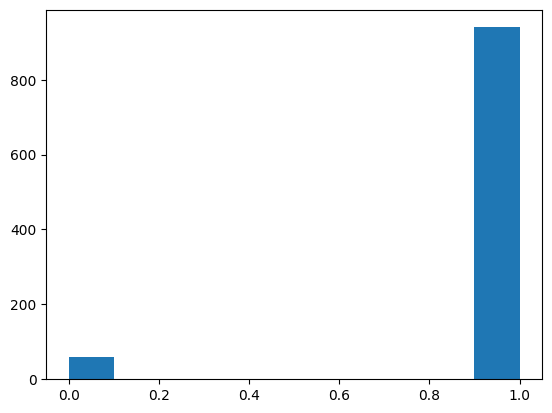

In [6]:
plt.hist(h[:, 0])

# Plot non-ft BioEmu results for many mutants

In [7]:
records = []

for mutation_dir in Path('../../bioemu-testing/protein_results/grb2-sh3/test0/').glob('*'):
    mutation_name = mutation_dir.name
    print(mutation_name)

    _, pos, orientations = read_dir(mutation_dir)
    h = observables.compute_h_for_grb2_sh3(pos, orientations, "structures/2vwf_trimmed_SH3.pdb")

    # rough proxy for dg_binding
    h_folded, h_bindable = h[:, 0], h[:, 1]
    dg_folding = -np.log((h_folded == 1).sum() / (h_folded == 0).sum()).item()
    dg_binding = -np.log((h_bindable == 1).sum() / (h_bindable == 0).sum()).item()

    records.append((mutation_name, dg_folding, dg_binding))

F19I
F19L
L6I
wt
T53G
H26T
W36K
P11L
D32F
M28Y
Q12E
D23Y
N56E
N56D
R49A
C40P
Y2D
D23F
D10I
G18N
Q43R
P33H
G45V
N56V
F7Y
V27G
D29I
C40F
K37G
D8H
D10N
V55D
F7P
Q43W
L17R
W36C
Q4S
R20C
G22W
Q12T
P11Q
V3P
G45N
V27Y
T53S
M46S
S31I
C40Y
G18H
G18T
D32C
N56H
Q4L
D32N
E16M
I25D
Q12H
W36G
H41D
V52S
T1L
D23S
T53V
R21A
S31E
A39Y
Y2N
P33S
W36V
G45S
F47Y
R20L
G22V
V3D
N34G
V27N
N34L
K37R
P54A
R49S
M46E
D14G
R21K
M46I
R21L
N34R
D8T
G38R
D23N
N56T
P33T
M46L
V27L
P54Q
M28L
Q43D
N50F
H26L
R20A
S31T
H41F
M28V
F24I
R49L
V55M
P48L
H41I
C40R
G22I
Y2C
M28R
T44S
R49G
R21W
Y51I
G45R
E16G
Y51H
F7S
T44F
F24T
L6H
D23A
W36L
V3T
H26E
W36F
G22Q
V3E
P48Y
F7T
G18I
R49Q
N50H
Q12V
D14F
D8F
H26I
Q4T
D14S
D29E
N30K
V3S
E13N
M46K
N30Y
R21P
D8I
Y2Q
V52P
M28G
G42C
N30T
R49T
N50Y
P48Q
F9L
T44V
G18D
A5G
N34E
R20P
G18C
M28S
G15W
N30D
P48S
R21H
E16V
H26A
L17M
H26R
G15Q
E13A
G42W
T1G
N56Y
N50S
G42D
Q43L
R20S
R49C
N50E
R21M
T1V
F24V
H41N
W36S
M28E
N50M
H26D
Q4M
M46T
T1M
I25L
F9I
N50D
G15V
D10G
T1K
E16D
W35C
H26N
P11H
Y2I
S31Y
R21G

In [8]:
h[:,0]

tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

<Axes: ylabel='Count'>

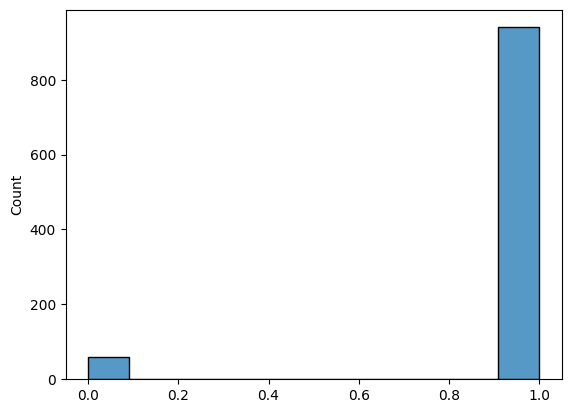

In [9]:
sns.histplot(h[:,0])

In [10]:
records

[('F19I', -2.4288370609283447, -1.7987771034240723),
 ('F19L', -2.277543067932129, -1.6434217691421509),
 ('L6I', -3.009467363357544, -2.1751973628997803),
 ('wt', -2.751535415649414, -1.9098296165466309),
 ('T53G', -2.2894558906555176, -1.6731849908828735),
 ('H26T', -2.4423470497131348, -1.8746898174285889),
 ('W36K', -1.2598483562469482, -0.9197933673858643),
 ('P11L', -2.6995484828948975, -1.6656874418258667),
 ('D32F', -2.7339415550231934, -1.9459102153778076),
 ('M28Y', -2.483823776245117, -1.807008981704712),
 ('Q12E', -2.6021528244018555, -1.8574546575546265),
 ('D23Y', -1.848917841911316, -1.300980806350708),
 ('N56E', -2.8060150146484375, -1.8921458721160889),
 ('N56D', -2.556365728378296, -1.7583270072937012),
 ('R49A', -2.965693712234497, -1.9924302101135254),
 ('C40P', -0.41380545496940613, 0.09206496924161911),
 ('Y2D', -2.6021528244018555, -1.9550845623016357),
 ('D23F', -2.1751973628997803, -1.6070398092269897),
 ('D10I', -2.666159152984619, -1.8236205577850342),
 ('G18

In [11]:
bioemu_non_ft_predictions = pd.DataFrame.from_records(records, columns=['id', 'dg_folding_est', 'dg_binding_est'])

# Adjust to ddgs. What we're estimating here is really something like a dg from "bindable" to nonbindable
# which can be viewed as a ddg of binding
#wt_est = bioemu_non_ft_predictions.loc[bioemu_non_ft_predictions['id'] == 'wt', 'dg_binding_est'].item()
#bioemu_non_ft_predictions['ddg_binding_est'] -= wt_est
# for purposes of h* it's easier just to stick with dg

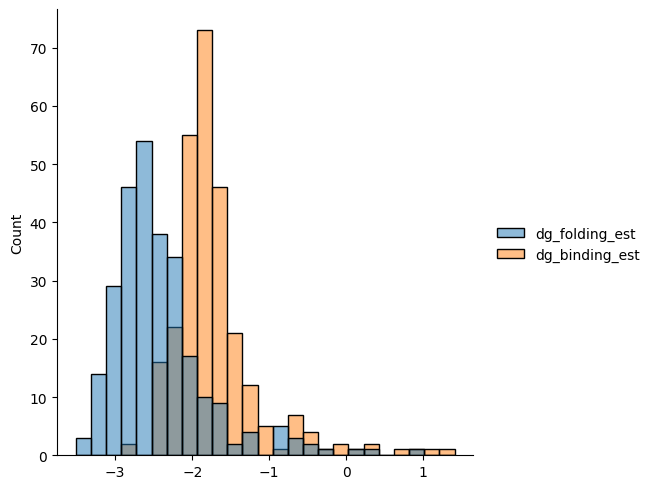

In [12]:
sns.displot(bioemu_non_ft_predictions)

# Compare to ground truth

In [13]:
gt_data = pd.read_csv('reference_h/GRB2_SH3_high_confidence.csv')
gt_data.loc[gt_data.id == '-0-', 'id'] = 'wt' # rename wt row

In [14]:
combined_df = gt_data.merge(bioemu_non_ft_predictions)

In [15]:
combined_df.columns

Index(['Pos_ref', 'id', 'id_ref', 'Pos', 'mut_order', 'f_dg_pred',
       'f_ddg_pred', 'f_ddg_pred_sd', 'b_dg_pred', 'b_ddg_pred',
       'b_ddg_pred_sd', 'f_ddg_pred_conf', 'b_ddg_pred_conf', 'HAmin_ligand',
       'scHAmin_ligand', 'RSASA', 'SS', 'Pos_class', 'protein', 'WT_AA', 'Mut',
       'b_ddg_wposmeanabs', 'b_ddg_wposse', 'allosteric', 'orthosteric',
       'allosteric_mutation', 'seq', 'dg_folding_est', 'dg_binding_est'],
      dtype='object')

In [16]:
combined_df.loc[combined_df.id=='wt']

,Pos_ref,id,id_ref,Pos,mut_order,f_dg_pred,f_ddg_pred,f_ddg_pred_sd,b_dg_pred,b_ddg_pred,...,WT_AA,Mut,b_ddg_wposmeanabs,b_ddg_wposse,allosteric,orthosteric,allosteric_mutation,seq,dg_folding_est,dg_binding_est
146,NaN,wt,-0-,NaN,0,-0.831471,0.0,0.0,-1.044962,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-2.751535,-1.90983


Text(0.5, 1.0, 'binding ddg change')

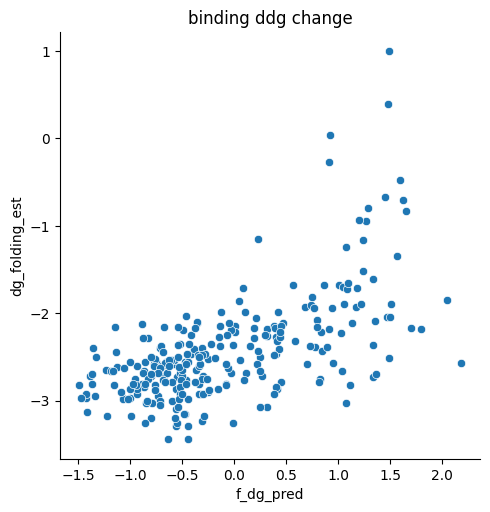

In [17]:
sns.relplot(combined_df, x='f_dg_pred', y='dg_folding_est')
plt.title('binding ddg change')

In [18]:
scipy.stats.spearmanr(combined_df.f_dg_pred, combined_df.dg_folding_est)

SignificanceResult(statistic=0.5939306192485225, pvalue=1.176295409497477e-26)

Text(0.5, 1.0, 'binding ddg change')

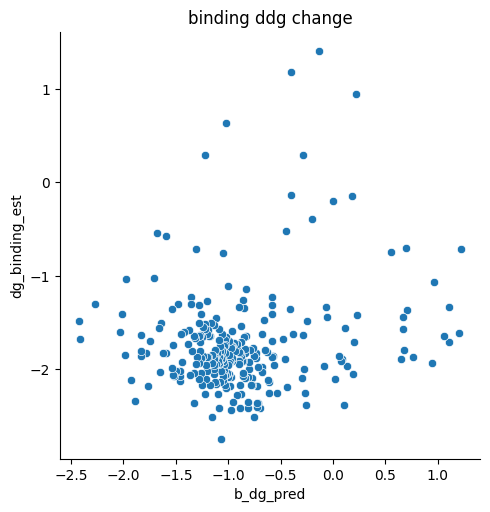

In [19]:
sns.relplot(combined_df, x='b_dg_pred', y='dg_binding_est')
plt.title('binding ddg change')

In [20]:
scipy.stats.spearmanr(combined_df.b_ddg_pred, combined_df.dg_binding_est)

SignificanceResult(statistic=0.012735596238331193, pvalue=0.8365184621130809)

# test h_star code

In [21]:
observables.h_star_for_grb2_sh3('reference_h/GRB2_SH3_high_confidence.csv')

(0      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTHM...
 1      TYVQALFDCDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 2      TYVQALFDVDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 3      TYVQALIDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 4      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNRWKGACHGQTGM...
                              ...                        
 584    TYVQALFCFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 585    TYVQALFDFDPQEDGELGFRRGYFIHVMDNSDPNWWKGACHGQTGM...
 586    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 587    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWDGACHGQTGM...
 588    TYVNALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 Name: seq, Length: 589, dtype: object,
 tensor([[0.1976, 0.0045],
         [0.5153, 0.1624],
         [0.5799, 0.1986],
         ...,
         [0.7065, 0.9182],
         [0.2275, 0.9187],
         [0.2778, 0.9362]]))